In [1]:
#### import global modules
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from yaml import safe_load
import google.oauth2.credentials
from google.cloud import bigquery
import gc

# Set global vars
pth_project = Path(os.getcwd().split('notebooks')[0])
pth_data = pth_project / 'data'
pth_queries = pth_project / 'core' / 'queries'
pth_creds = pth_project / 'conf' / 'local' / 'project_config.yaml'
sys.path.insert(0, str(pth_project))
d_project_config = safe_load(pth_creds.open())
# d_params = safe_load((pth_project / 'core' / 'parameters' / 'common.yaml').open())['data_extract']

# import local modules
from core.utils.gcp import connect_bq_services
# from core.etl.extract import extract_bq_data, extract_pr_codes, format_conv_df, filter_convs

# Connect to google services
bq_client = connect_bq_services(d_project_config['gcp-project-name'])
pd.options.display.max_rows = 100

In [2]:
def extract_bq_data(bq_client, sql=None, pth_query=None):
    if sql is not None:
        df = bq_client.query(sql).to_dataframe()
    elif pth_query is not None:
        sql = pth_query.read_text()
        df = bq_client.query(sql).to_dataframe()
    else:
        raise ValueError('`sql` or `pth_query` should be set')  
    return df

In [3]:
Telus_Customer_details='''



with ADC_customer_base as(

SELECT customer_id,dealer_customer_id,dealer_name
FROM `cio-datahub-enterprise-pr-183a.src_adc.bq_customer_account_details` 
where date(last_updt_ts) ='2022-08-31'
and account_type_name!='Standalone'
and customer_type_name='Customer'
and dealer_name='TELUS Communications Inc.'
QUALIFY ROW_NUMBER() OVER (PARTITION BY customer_id ORDER BY last_updt_ts DESC) = 1
order by dealer_name,join_date,customer_id
)
,

Telus_customers as
(

select bacct_bus_bacct_num,bacct_billg_acct_id,cust_bus_cust_id,pi_prod_instnc_typ_cd,pi_prod_instnc_stat_ts,prod_instnc_ts,pi_cntrct_end_ts as contract_end_date
from `cio-datahub-enterprise-pr-183a.ent_cust_cust.bq_prod_instnc_snpsht` 
WHERE DATE(prod_instnc_ts) = "2022-08-31" #Snapshot of the last day of the month
and pi_prod_instnc_typ_cd ='SMHM' #Serice type
and bus_prod_instnc_src_id = 1001 #BANs that are for home services
and pi_prod_instnc_stat_cd in ('A')
and  consldt_cust_typ_cd = 'R'
QUALIFY ROW_NUMBER() OVER (PARTITION BY cust_bus_cust_id ORDER BY pi_prod_instnc_stat_ts DESC) = 1
order by cust_bus_cust_id

)








select * from ADC_customer_base as adc
inner join Telus_customers as telus
on telus.cust_bus_cust_id=adc.dealer_customer_id

'''

In [4]:
Telus_Customer_info=extract_bq_data(bq_client, sql=Telus_Customer_details)

In [5]:
Telus_Customer_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260495 entries, 0 to 260494
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   customer_id             260495 non-null  Int64 
 1   dealer_customer_id      260495 non-null  object
 2   dealer_name             260495 non-null  object
 3   bacct_bus_bacct_num     260495 non-null  Int64 
 4   bacct_billg_acct_id     260495 non-null  Int64 
 5   cust_bus_cust_id        260495 non-null  object
 6   pi_prod_instnc_typ_cd   260495 non-null  object
 7   pi_prod_instnc_stat_ts  260495 non-null  object
 8   prod_instnc_ts          260495 non-null  object
 9   contract_end_date       260495 non-null  object
dtypes: Int64(3), object(7)
memory usage: 20.6+ MB


In [6]:
Telus_Customer_info.head()

,customer_id,dealer_customer_id,dealer_name,bacct_bus_bacct_num,bacct_billg_acct_id,cust_bus_cust_id,pi_prod_instnc_typ_cd,pi_prod_instnc_stat_ts,prod_instnc_ts,contract_end_date
0,4738487,98349862,TELUS Communications Inc.,603601779,97744355,98349862,SMHM,2018-07-20 19:00:00,2022-08-31 00:00:00+00:00,2019-11-23 00:00:00
1,4911678,98341611,TELUS Communications Inc.,603601083,97743446,98341611,SMHM,2018-07-20 19:00:00,2022-08-31 00:00:00+00:00,2019-12-19 00:00:00
2,5004762,99856839,TELUS Communications Inc.,604049149,99927000,99856839,SMHM,2019-10-10 00:00:00,2022-08-31 00:00:00+00:00,2020-01-30 00:00:00
3,5031118,98335310,TELUS Communications Inc.,603575291,97715898,98335310,SMHM,2018-07-20 19:00:00,2022-08-31 00:00:00+00:00,2023-05-29 00:00:00
4,5080294,98352781,TELUS Communications Inc.,603598980,97741186,98352781,SMHM,2018-07-20 19:00:00,2022-08-31 00:00:00+00:00,2020-03-10 00:00:00


In [646]:
ADC_Resi_DF_query='''



with ADC_resi_base as


(

select * from `divgpras-pr-579355.ADC_updated.ADC_resi_customers_base_31Aug2022`


),

telus_churn as (


select cust_bus_cust_id,1 as Telus_Churn,pi_prod_instnc_stat_ts as churn_date_telus
from `cio-datahub-enterprise-pr-183a.ent_cust_cust.bq_prod_instnc_snpsht` 
WHERE DATE(prod_instnc_ts) = "2022-10-01" #Snapshot of the last day of the month
and pi_prod_instnc_typ_cd ='SMHM' #Serice type
and bus_prod_instnc_src_id = 1001 #BANs that are for home services
and pi_prod_instnc_stat_cd in ('C')
and DATE(pi_prod_instnc_stat_ts)>='2022-09-01' and DATE(pi_prod_instnc_stat_ts)<'2022-10-01' #Date on which the status was updated
QUALIFY ROW_NUMBER() OVER (PARTITION BY cust_bus_cust_id ORDER BY pi_prod_instnc_stat_ts DESC) = 1
order by pi_cntrct_end_ts


)



select * from ADC_resi_base as adc
left join telus_churn as telus
on telus.cust_bus_cust_id=adc.dealer_customer_id
order by Telus_Churn desc

'''

In [647]:
ADC_resi_DF=extract_bq_data(bq_client, sql=ADC_Resi_DF_query)

In [648]:
ADC_resi_DF.head()

,dealer_id,dealer_name,dealer_branch_id,dealer_branch_desc,customer_id,title,lastname,firstname,address1,address2,...,create_ts,create_user_id,last_updt_ts,last_updt_user_id,customer_id_1,Dealer_type_flag,RowCnt,cust_bus_cust_id,Telus_Churn,churn_date_telus
0,15525,TELUS Communications Inc.,None,,4907827,,Khanna,Phalguni,223,Cranarch Landing SE,...,2022-08-31 11:59:52.034161+00:00,etl_cust,2022-08-31 11:59:52.034161+00:00,etl_cust,4907827,Telus_Customer,260495,98342068,1,2022-09-15
1,15525,TELUS Communications Inc.,None,,5573154,,VOERMANS,M/M,47,PARKWOOD CRES,...,2022-08-31 11:59:52.034161+00:00,etl_cust,2022-08-31 11:59:52.034161+00:00,etl_cust,5573154,Telus_Customer,260495,98353799,1,2022-09-14
2,15525,TELUS Communications Inc.,None,,6528499,,Goulding,Erin,9 COUNTRY MEADOWS PL,,...,2022-08-31 11:59:52.034161+00:00,etl_cust,2022-08-31 11:59:52.034161+00:00,etl_cust,6528499,Telus_Customer,260495,2355194,1,2022-09-15
3,15525,TELUS Communications Inc.,None,,7214079,,MacLean,Linda,81 LEGACY COMMON SE,,...,2022-08-31 11:59:52.034161+00:00,etl_cust,2022-08-31 11:59:52.034161+00:00,etl_cust,7214079,Telus_Customer,260495,84789215,1,2022-09-20
4,15525,TELUS Communications Inc.,None,,7914891,,Conine,Bryce,129 BLUEFOX BLVD N,,...,2022-08-31 11:59:52.034161+00:00,etl_cust,2022-08-31 11:59:52.034161+00:00,etl_cust,7914891,Telus_Customer,260495,1860305,1,2022-09-21


In [649]:
ADC_resi_DF['Telus_Churn'].sum()

3434

In [650]:
Churn_Customers='''


select customer_id,term_date,term_reason,1 as Churn_flag from `cio-datahub-enterprise-pr-183a.src_adc.bq_customer_account_terminated_details`
where date(term_date) >= '2022-09-01' and date(term_date) < '2022-10-01'


'''

In [651]:
Churn_DF_Sep2022=extract_bq_data(bq_client, sql=Churn_Customers)

In [652]:
Churn_DF_Sep2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11918 entries, 0 to 11917
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   customer_id  11918 non-null  Int64              
 1   term_date    11918 non-null  datetime64[ns, UTC]
 2   term_reason  11918 non-null  Int64              
 3   Churn_flag   11918 non-null  Int64              
dtypes: Int64(3), datetime64[ns, UTC](1)
memory usage: 407.5 KB


In [653]:
Churn_DF_Sep2022['term_date'].min()

Timestamp('2022-09-08 00:00:05+0000', tz='UTC')

In [654]:
Churn_DF_Sep2022['term_date'].max()

Timestamp('2022-09-30 23:02:31+0000', tz='UTC')

In [655]:
Churn_DF_Sep2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11918 entries, 0 to 11917
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   customer_id  11918 non-null  Int64              
 1   term_date    11918 non-null  datetime64[ns, UTC]
 2   term_reason  11918 non-null  Int64              
 3   Churn_flag   11918 non-null  Int64              
dtypes: Int64(3), datetime64[ns, UTC](1)
memory usage: 407.5 KB


In [656]:
All_DF=ADC_resi_DF.merge(Churn_DF_Sep2022,on='customer_id',how='left')

In [657]:
All_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447141 entries, 0 to 447140
Data columns (total 59 columns):
 #   Column                            Non-Null Count   Dtype              
---  ------                            --------------   -----              
 0   dealer_id                         447141 non-null  Int64              
 1   dealer_name                       447141 non-null  object             
 2   dealer_branch_id                  182721 non-null  object             
 3   dealer_branch_desc                447141 non-null  object             
 4   customer_id                       447141 non-null  Int64              
 5   title                             447141 non-null  object             
 6   lastname                          447141 non-null  object             
 7   firstname                         447141 non-null  object             
 8   address1                          447141 non-null  object             
 9   address2                          447141 non-nul

In [737]:
pd.DataFrame(All_DF.groupby(['dealer_name']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total_telus=('Telus_Churn',lambda x: x.sum()),
    Churn_rate_telus=('Telus_Churn',lambda x: x.mean()*100),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,dealer_name,Customer_count,Churn_total_telus,Churn_rate_telus,Churn_total,Churn_rate
0,ADT by TELUS,201279,10,100,2704,1.343409
1,TELUS Communications Inc.,245862,3424,100,2890,1.175456


In [660]:
3424-2890

534

In [661]:
All_DF['Churn_flag'].fillna(0,inplace=True)

In [662]:
Best_Practices_Query= '''

select * from `divgpras-pr-579355.ADC.Best_Practices_Customers`

'''

In [663]:
Best_Practices_DF=extract_bq_data(bq_client, sql=Best_Practices_Query)

In [664]:
Best_Practices_DF.head()

,customer_id,Best_partices_1,Best_partices_2,Best_partices_3,Best_partices_4,Best_partices_5,Best_partices_6,Best_Practice_All,Best_Practice_All_flag
0,7083581,1,1,0,1,1,0,4,0
1,11485100,1,1,0,1,1,0,4,0
2,7083536,1,1,0,1,1,0,4,0
3,11431346,1,1,0,1,1,0,4,0
4,13527450,1,1,0,1,1,0,4,0


In [665]:
Arming_Query='''



with date_sql as (
select  count(distinct date(date)) as count_of_dates from `cio-datahub-enterprise-pr-183a.src_adc.bq_aggregate_daily_arming_commands`
where date(date)< '2022-09-01'
)



select id_cust as customer_id,sum(count_arm_commands) as sum_arm_commands,sum(count_disarm_commands) as sum_disarm_commands,count (distinct date(date)) as number_days_arming_disarming, (select count_of_dates from date_sql ) as count_of_dates_arming
from `cio-datahub-enterprise-pr-183a.src_adc.bq_aggregate_daily_arming_commands`
where date(date)< '2022-09-01'
group by customer_id
order by number_days_arming_disarming desc





'''

In [666]:
Arming_DF=extract_bq_data(bq_client, sql=Arming_Query)

In [667]:
Arming_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309292 entries, 0 to 309291
Data columns (total 5 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   customer_id                   309292 non-null  Int64
 1   sum_arm_commands              309292 non-null  Int64
 2   sum_disarm_commands           309292 non-null  Int64
 3   number_days_arming_disarming  309292 non-null  Int64
 4   count_of_dates_arming         309292 non-null  Int64
dtypes: Int64(5)
memory usage: 13.3 MB


In [668]:
Arming_DF.head()

,customer_id,sum_arm_commands,sum_disarm_commands,number_days_arming_disarming,count_of_dates_arming
0,6768795,33,25,18,18
1,13857862,52,35,18,18
2,13944560,53,36,18,18
3,9802076,25,27,18,18
4,9785208,46,45,18,18


In [669]:

max_number_arming_dates=Arming_DF['count_of_dates_arming'].max()
Arming_DF['Arming_Consistency']=Arming_DF['number_days_arming_disarming'].apply(lambda x: x*100/max_number_arming_dates)


In [670]:
Arming_DF['Arming_Flag']=1

In [671]:
Login_SQL='''

with date_sql as (
select  count(distinct date(login_dt_utc)) as count_of_dates from `cio-datahub-enterprise-pr-183a.src_adc.bq_customer_daily_logins`
where date(login_dt_utc)< '2022-09-01'

)



select customer_id,sum(login_count) as sum_login_count,count (distinct date(login_dt_utc)) as number_of_login_days, (select count_of_dates from date_sql ) as count_of_dates_logins
from `cio-datahub-enterprise-pr-183a.src_adc.bq_customer_daily_logins`
where date(login_dt_utc)< '2022-09-01'
group by customer_id
order by number_of_login_days desc


'''

In [672]:
Login_DF=extract_bq_data(bq_client, sql=Login_SQL)

In [673]:
Login_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153122 entries, 0 to 153121
Data columns (total 4 columns):
 #   Column                 Non-Null Count   Dtype
---  ------                 --------------   -----
 0   customer_id            153122 non-null  Int64
 1   sum_login_count        153122 non-null  Int64
 2   number_of_login_days   153122 non-null  Int64
 3   count_of_dates_logins  153122 non-null  Int64
dtypes: Int64(4)
memory usage: 5.3 MB


In [674]:
max_number_login_dates=Login_DF['count_of_dates_logins'].max()
Login_DF['Login_Consistency']=Login_DF['number_of_login_days'].apply(lambda x: x*100/max_number_login_dates)

In [675]:
Merge_DF=All_DF.merge(Best_Practices_DF,on='customer_id',how='left')

In [676]:
Merge_DF_1=Merge_DF.merge(Arming_DF,on='customer_id',how='left')

In [677]:
Merge_DF_2=Merge_DF_1.merge(Login_DF,on='customer_id',how='left')

In [678]:
Merge_DF_2.head()

,dealer_id,dealer_name,dealer_branch_id,dealer_branch_desc,customer_id,title,lastname,firstname,address1,address2,...,sum_arm_commands,sum_disarm_commands,number_days_arming_disarming,count_of_dates_arming,Arming_Consistency,Arming_Flag,sum_login_count,number_of_login_days,count_of_dates_logins,Login_Consistency
0,15525,TELUS Communications Inc.,None,,4907827,,Khanna,Phalguni,223,Cranarch Landing SE,...,22,20,18,18,100.000000,1.0,<NA>,<NA>,<NA>,NaN
1,15525,TELUS Communications Inc.,None,,5573154,,VOERMANS,M/M,47,PARKWOOD CRES,...,<NA>,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN
2,15525,TELUS Communications Inc.,None,,6528499,,Goulding,Erin,9 COUNTRY MEADOWS PL,,...,7,7,6,18,33.333333,1.0,<NA>,<NA>,<NA>,NaN
3,15525,TELUS Communications Inc.,None,,7214079,,MacLean,Linda,81 LEGACY COMMON SE,,...,<NA>,<NA>,<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,NaN
4,15525,TELUS Communications Inc.,None,,7914891,,Conine,Bryce,129 BLUEFOX BLVD N,,...,19,17,13,18,72.222222,1.0,<NA>,<NA>,<NA>,NaN


In [679]:
Merge_DF_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447141 entries, 0 to 447140
Data columns (total 77 columns):
 #   Column                            Non-Null Count   Dtype              
---  ------                            --------------   -----              
 0   dealer_id                         447141 non-null  Int64              
 1   dealer_name                       447141 non-null  object             
 2   dealer_branch_id                  182721 non-null  object             
 3   dealer_branch_desc                447141 non-null  object             
 4   customer_id                       447141 non-null  Int64              
 5   title                             447141 non-null  object             
 6   lastname                          447141 non-null  object             
 7   firstname                         447141 non-null  object             
 8   address1                          447141 non-null  object             
 9   address2                          447141 non-nul

In [680]:
Merge_DF_2.fillna(0,inplace=True)

In [681]:
def Segment_making(row
                   ,min_login_consistency_threshold=50
                   ,min_arming_consistency_threshold=50
                   ,max_login_consistency_threshold=50
                   ,max_arming_consistency_threshold=50):
    
    if row['Best_Practice_All']>=5 and row['Login_Consistency']>=max_login_consistency_threshold  and row['Arming_Consistency']>=max_arming_consistency_threshold:
        return 'Heavy_User'
    elif row['Login_Consistency']>=max_login_consistency_threshold  and row['Arming_Consistency']< min_arming_consistency_threshold:
        return 'Home_automation_Savvy'
    elif row['Login_Consistency']< min_login_consistency_threshold  and row['Arming_Consistency']>=max_login_consistency_threshold:
        return 'Old_Fashion'
    elif row['Login_Consistency']==0  and row['Arming_Consistency']==0:
        return 'Disengaged'
    else:
        return "Moderate_Users"

In [682]:
Merge_DF_2['Segment']=Merge_DF_2.apply(Segment_making,axis=1)

In [683]:
Merge_DF_2['Segment'].value_counts(normalize=True)*100

Disengaged               39.950262
Moderate_Users           24.822148
Old_Fashion              24.133327
Home_automation_Savvy     7.273992
Heavy_User                3.820271
Name: Segment, dtype: float64

In [684]:
Merge_DF_2['Segment'].value_counts()

Disengaged               178634
Moderate_Users           110990
Old_Fashion              107910
Home_automation_Savvy     32525
Heavy_User                17082
Name: Segment, dtype: int64

In [685]:
Merge_DF_2['Churn_flag'].value_counts(normalize=True)*100

0    98.74894
1     1.25106
Name: Churn_flag, dtype: Float64

In [686]:
pd.DataFrame(Merge_DF_2.groupby(['dealer_name']).agg(

    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)


).reset_index())

,dealer_name,Customer_count,Churn_total,Churn_rate
0,ADT by TELUS,201279,2704,1.343409
1,TELUS Communications Inc.,245862,2890,1.175456


In [687]:
pd.DataFrame(Merge_DF_2.groupby(['Segment']).agg(
       Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).sort_values('Customer_count',ascending=False).reset_index())

,Segment,Customer_count,Churn_total,Churn_rate
0,Disengaged,178634,3064,1.715239
1,Moderate_Users,110990,1344,1.210920
2,Old_Fashion,107910,715,0.662589
3,Home_automation_Savvy,32525,367,1.128363
4,Heavy_User,17082,104,0.608828


In [688]:
pd.DataFrame(Merge_DF_2.groupby(['Best_Practice_All']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,Best_Practice_All,Customer_count,Churn_total,Churn_rate
0,0,22363,427,1.909404
1,1,20846,341,1.635805
2,2,45750,689,1.506011
3,3,68330,853,1.248354
4,4,139039,1571,1.129899
5,5,112936,1304,1.154636
6,6,37877,409,1.079811


In [689]:
pd.DataFrame(Merge_DF_2.groupby(['Best_partices_1']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,Best_partices_1,Customer_count,Churn_total,Churn_rate
0,0,47816,858,1.794378
1,1,399325,4736,1.186001


In [690]:
pd.DataFrame(Merge_DF_2.groupby(['Best_partices_2']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,Best_partices_2,Customer_count,Churn_total,Churn_rate
0,0,76044,1166,1.533323
1,1,371097,4428,1.193219


In [691]:
pd.DataFrame(Merge_DF_2.groupby(['Best_partices_3']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,Best_partices_3,Customer_count,Churn_total,Churn_rate
0,0,284699,3712,1.303833
1,1,162442,1882,1.158567


In [692]:
pd.DataFrame(Merge_DF_2.groupby(['Best_partices_4']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,Best_partices_4,Customer_count,Churn_total,Churn_rate
0,0,327650,4123,1.258355
1,1,119491,1471,1.231055


In [693]:
pd.DataFrame(Merge_DF_2.groupby(['Best_partices_5']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,Best_partices_5,Customer_count,Churn_total,Churn_rate
0,0,106769,1667,1.561315
1,1,340372,3927,1.153738


In [694]:
pd.DataFrame(Merge_DF_2.groupby(['Best_partices_6']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,Best_partices_6,Customer_count,Churn_total,Churn_rate
0,0,174434,2502,1.434353
1,1,272707,3092,1.133818


In [695]:
Telus_internet_customers_query='''

select * from `divgpras-pr-579355.ADC_updated.ADC_Telus_internet_customers_31Aug2022`

'''

In [696]:
Telus_internet_DF=extract_bq_data(bq_client, sql=Telus_internet_customers_query)

In [697]:
Telus_internet_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184624 entries, 0 to 184623
Data columns (total 12 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   customer_id                     184624 non-null  Int64              
 1   dealer_customer_id              184624 non-null  object             
 2   dealer_name                     184624 non-null  object             
 3   bacct_bus_bacct_num             184624 non-null  Int64              
 4   bacct_billg_acct_id             184624 non-null  Int64              
 5   cust_bus_cust_id                184624 non-null  object             
 6   pi_prod_instnc_typ_cd           184624 non-null  object             
 7   pi_prod_instnc_stat_ts          184624 non-null  datetime64[ns]     
 8   prod_instnc_ts                  184624 non-null  datetime64[ns, UTC]
 9   cust_bus_cust_id_internet       184624 non-null  object             
 

In [698]:
Merge_DF_3=Merge_DF_2.merge(Telus_internet_DF[['customer_id','Telus_internet_flag']],how='left',on='customer_id')

In [699]:
Merge_DF_3['Telus_internet_flag'].sum()

175577

In [700]:
Telus_DF=Merge_DF_3[Merge_DF_3['dealer_name']=='TELUS Communications Inc.']

In [701]:
Telus_DF['Telus_internet_flag'].sum()

175577

In [702]:
Telus_DF['Telus_internet_flag'].fillna(0,inplace=True)

/tmp/ipykernel_5889/199913899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Telus_DF['Telus_internet_flag'].fillna(0,inplace=True)


In [703]:
Telus_DF['Churn_flag'].value_counts(normalize=True)*100

0    98.824544
1     1.175456
Name: Churn_flag, dtype: Float64

In [704]:
pd.DataFrame(Telus_DF.groupby(['Telus_internet_flag']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,Telus_internet_flag,Customer_count,Churn_total,Churn_rate
0,0,70285,1142,1.624813
1,1,175577,1748,0.995575


In [705]:
Camera_TC_issue_query='''

select dealer_name,customer_id,unit_id,device_id,trouble_condition_name,trouble_condition_group_id,trouble_condition_group_desc, start_date_utc,end_date_utc
from `cio-datahub-enterprise-pr-183a.src_adc.bq_troublecondition_data`
where trouble_condition_start_ind='Y'and trouble_condition_closed_ind='Y' and date(start_date_utc) >= '2022-06-01' and date(start_date_utc) <'2022-09-01' and trouble_condition_name in ('CameraNotReachable','CameraNotCommunicating','BroadbandCommFailure')


'''

In [706]:
Camera_TC= extract_bq_data(bq_client, sql=Camera_TC_issue_query)

In [707]:
Camera_TC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2275115 entries, 0 to 2275114
Data columns (total 9 columns):
 #   Column                        Dtype              
---  ------                        -----              
 0   dealer_name                   object             
 1   customer_id                   Int64              
 2   unit_id                       Int64              
 3   device_id                     Int64              
 4   trouble_condition_name        object             
 5   trouble_condition_group_id    Int64              
 6   trouble_condition_group_desc  object             
 7   start_date_utc                datetime64[ns, UTC]
 8   end_date_utc                  datetime64[ns, UTC]
dtypes: Int64(4), datetime64[ns, UTC](2), object(3)
memory usage: 164.9+ MB


In [708]:
Camera_TC['count_instance']=1

TC_pivot_table=pd.pivot_table(Camera_TC, values=['count_instance'], index=['customer_id'], columns='trouble_condition_name',
                          aggfunc={'count_instance': np.sum})

In [709]:
TC_pivot_table=TC_pivot_table.reset_index()

In [710]:
TC_pivot_table.head()

customer_id       count_instance  \
trouble_condition_name             BroadbandCommFailure   
0                           213860                  2.0   
1                           229153                  NaN   
2                           287850                 20.0   
3                           292877                  3.0   
4                           299100                131.0   

                                                                  
trouble_condition_name CameraNotCommunicating CameraNotReachable  
0                                         NaN                NaN  
1                                         NaN                1.0  
2                                         NaN                NaN  
3                                         NaN                NaN  
4                                         NaN                NaN

In [711]:
TC_pivot_table.columns=['customer_id','BroadbandCommFailure_count','CameraNotCommunicating_count','CameraNotReachable_count']

In [712]:
TC_pivot_table['BroadbandCommFailure_Flag']=TC_pivot_table['BroadbandCommFailure_count'].apply(lambda x: 1 if x>0 else 0)
TC_pivot_table['CameraNotCommunicating_Flag']=TC_pivot_table['CameraNotCommunicating_count'].apply(lambda x: 1 if x>0 else 0)
TC_pivot_table['CameraNotReachable_Flag']=TC_pivot_table['CameraNotReachable_count'].apply(lambda x: 1 if x>0 else 0)

In [713]:
Merge_DF_4=Merge_DF_3.merge(TC_pivot_table,on='customer_id',how='left')

In [714]:
Merge_DF_5=Merge_DF_4.merge(Telus_Customer_info[['customer_id','contract_end_date']],on='customer_id',how='left')

In [715]:
Merge_DF_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447141 entries, 0 to 447140
Data columns (total 86 columns):
 #   Column                            Non-Null Count   Dtype              
---  ------                            --------------   -----              
 0   dealer_id                         447141 non-null  Int64              
 1   dealer_name                       447141 non-null  object             
 2   dealer_branch_id                  447141 non-null  object             
 3   dealer_branch_desc                447141 non-null  object             
 4   customer_id                       447141 non-null  Int64              
 5   title                             447141 non-null  object             
 6   lastname                          447141 non-null  object             
 7   firstname                         447141 non-null  object             
 8   address1                          447141 non-null  object             
 9   address2                          447141 non-nul

In [716]:
Merge_DF_5['Telus_Churn'].isnull().sum()

0

In [717]:
Merge_DF_5['Telus_Churn'].value_counts()

0    443707
1      3434
Name: Telus_Churn, dtype: Int64

In [718]:
Merge_DF_5['Churn_flag'].isna().sum()

0

In [719]:
Merge_DF_5['Churn_flag'].value_counts()

0    441547
1      5594
Name: Churn_flag, dtype: Int64

In [720]:
# def telus_delta(row):
#     if row['Telus_Churn']!=row['Churn_flag']:
#         1
#     else:
#         0
    
    

In [721]:
Merge_DF_5['Delta_Telus']=Merge_DF_5.apply(lambda x:1 if x['Telus_Churn']!=x['Churn_flag'] else 0,axis=1)

In [722]:
Telus_delta_DF=Merge_DF_5[(Merge_DF_5['dealer_name']=='TELUS Communications Inc.') & (Merge_DF_5['Delta_Telus']==1) ]

In [723]:
Telus_delta_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1422 entries, 6 to 446926
Data columns (total 87 columns):
 #   Column                            Non-Null Count  Dtype              
---  ------                            --------------  -----              
 0   dealer_id                         1422 non-null   Int64              
 1   dealer_name                       1422 non-null   object             
 2   dealer_branch_id                  1422 non-null   object             
 3   dealer_branch_desc                1422 non-null   object             
 4   customer_id                       1422 non-null   Int64              
 5   title                             1422 non-null   object             
 6   lastname                          1422 non-null   object             
 7   firstname                         1422 non-null   object             
 8   address1                          1422 non-null   object             
 9   address2                          1422 non-null   object     

In [724]:
Telus_delta_DF.head()

,dealer_id,dealer_name,dealer_branch_id,dealer_branch_desc,customer_id,title,lastname,firstname,address1,address2,...,Segment,Telus_internet_flag,BroadbandCommFailure_count,CameraNotCommunicating_count,CameraNotReachable_count,BroadbandCommFailure_Flag,CameraNotCommunicating_Flag,CameraNotReachable_Flag,contract_end_date,Delta_Telus
6,15525,TELUS Communications Inc.,0,,8957919,,Babatunde,Adebimpe,104 COUGARTOWN CL SW,,...,Disengaged,1,NaN,NaN,3.0,0.0,0.0,1.0,2023-04-22 00:00:00,1
7,15525,TELUS Communications Inc.,0,,9115713,TS h,testprod,telusshs,10035 102 ave,,...,Moderate_Users,<NA>,1609.0,NaN,NaN,1.0,0.0,0.0,2023-04-16 00:00:00,1
11,15525,TELUS Communications Inc.,0,,12127710,,LAMBERT,DANY,11 3575 RUE SAINT-ZOTIQUE E,,...,Disengaged,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,9999-12-31 00:00:00,1
14,15525,TELUS Communications Inc.,0,,12485936,,HILL,ALAN,2210 GALLAGHER AVE,,...,Disengaged,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,2026-11-04 00:00:00,1
19,15525,TELUS Communications Inc.,0,,13641878,,BOISVERT,LUCIE,4473 CHEMIN DES PLAINES,,...,Disengaged,<NA>,NaN,NaN,1.0,0.0,0.0,1.0,9999-12-31 00:00:00,1


In [726]:
Telus_delta_DF['Telus_Churn'].sum()

978

In [727]:
Telus_delta_missed_DF=Telus_delta_DF[Telus_delta_DF['Telus_Churn']==1]

In [730]:
Telus_delta_missed_DF['Delta_Telus'].sum()

978

In [731]:
Telus_delta_missed_DF['Churn_flag'].sum()

0

In [732]:
Telus_delta_missed_DF.columns.to_list()

['dealer_id',
 'dealer_name',
 'dealer_branch_id',
 'dealer_branch_desc',
 'customer_id',
 'title',
 'lastname',
 'firstname',
 'address1',
 'address2',
 'city',
 'state',
 'postal_code',
 'join_date',
 'term_date_x',
 'term_reason_x',
 'rep_id',
 'company_name',
 'dealer_customer_id',
 'primary_login_id',
 'original_dealer_id',
 'originial_dealer_branch_id',
 'country_id',
 'county_name',
 'first_login_time',
 'account_type',
 'account_type_name',
 'suspended_date_utc',
 'customer_type',
 'customer_type_name',
 'customer_type_entry_date_utc',
 'last_web_access_date_utc',
 'last_mobile_access_date_utc',
 'enabled_for_upsell_offers',
 'package_template_id',
 'package_template_name',
 'account_recycle_reason_id',
 'account_recycle_reason_type_desc',
 'upsell_account_type',
 'ready_date_utc',
 'install_type_id',
 'install_type_desc',
 'builder_program_model_home',
 'primary_email',
 'primary_phone',
 'file_name',
 'create_ts',
 'create_user_id',
 'last_updt_ts',
 'last_updt_user_id',
 'cu

In [733]:
cols_req=['customer_id','dealer_name','dealer_customer_id','Telus_Churn','churn_date_telus','Churn_flag','term_date_y','term_reason_y','Telus_internet_flag','Segment','contract_end_date','Delta_Telus',]
Telus_delta_missed_DF=Telus_delta_missed_DF[cols_req]

In [736]:
config= bigquery.job.LoadJobConfig()

# config._properties['timePartitioning'] = {'field': 'Month_Year'}
config.write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE

Table_BQ = 'ADC_updated.Telus_ADC_missed_churn'

bq_table_instance= bq_client.load_table_from_dataframe(Telus_delta_missed_DF, Table_BQ,job_config=config)

In [233]:
Disengaged_DF=Merge_DF_5[Merge_DF_5['Segment']=='Disengaged']

In [234]:
Disengaged_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178634 entries, 1 to 447140
Data columns (total 85 columns):
 #   Column                            Non-Null Count   Dtype              
---  ------                            --------------   -----              
 0   dealer_id                         178634 non-null  Int64              
 1   dealer_name                       178634 non-null  object             
 2   dealer_branch_id                  178634 non-null  object             
 3   dealer_branch_desc                178634 non-null  object             
 4   customer_id                       178634 non-null  Int64              
 5   title                             178634 non-null  object             
 6   lastname                          178634 non-null  object             
 7   firstname                         178634 non-null  object             
 8   address1                          178634 non-null  object             
 9   address2                          178634 non-nul

In [235]:
Disengaged_DF['dealer_name'].value_counts()

TELUS Communications Inc.    142802
ADT by TELUS                  35832
Name: dealer_name, dtype: int64

In [236]:
Disengaged_DF['contract_end_date'].isna().sum()

35832

In [240]:
Disengaged_DF['Telus_Churn'].sum()

2438

In [241]:
Disengaged_DF['Churn_flag'].sum()

3064

In [239]:
pd.DataFrame(Disengaged_DF.groupby(['Best_Practice_All']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Telus_Churn_total=('Telus_Churn',lambda x: x.sum()),
    Telus_Churn_rate=('Telus_Churn',lambda x: x.mean()*100),    
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)

).reset_index())

,Best_Practice_All,Customer_count,Telus_Churn_total,Telus_Churn_rate,Churn_total,Churn_rate
0,0,12020,183,1.522463,318,2.645591
1,1,9308,140,1.504083,244,2.621401
2,2,17711,233,1.315567,376,2.122974
3,3,28100,369,1.313167,494,1.758007
4,4,58448,759,1.298590,831,1.421777
5,5,42734,610,1.427435,631,1.476576
6,6,10313,144,1.396296,170,1.648405


In [243]:
pd.DataFrame(Disengaged_DF.groupby(['Best_partices_1']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,Best_partices_1,Customer_count,Churn_total,Churn_rate
0,0,24030,624,2.596754
1,1,154604,2440,1.578226


In [244]:
pd.DataFrame(Disengaged_DF.groupby(['Best_Practice_All']).agg(
    BroadbandCommFailure_count=('BroadbandCommFailure_Flag',np.sum),
    CameraNotCommunicating_count=('CameraNotCommunicating_Flag',np.sum), 
    CameraNotReachable_count=('CameraNotReachable_Flag',np.sum)).reset_index())

,Best_Practice_All,BroadbandCommFailure_count,CameraNotCommunicating_count,CameraNotReachable_count
0,0,182.0,0.0,3.0
1,1,535.0,16.0,32.0
2,2,1309.0,236.0,327.0
3,3,1419.0,744.0,1241.0
4,4,4537.0,2027.0,4060.0
5,5,2832.0,2340.0,4396.0
6,6,748.0,763.0,1374.0


In [245]:
pd.DataFrame(Disengaged_DF.groupby(['BroadbandCommFailure_Flag']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,BroadbandCommFailure_Flag,Customer_count,Churn_total,Churn_rate
0,0.0,13910,180,1.294033
1,1.0,11562,167,1.444387


In [246]:
pd.DataFrame(Disengaged_DF.groupby(['CameraNotCommunicating_Flag']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,CameraNotCommunicating_Flag,Customer_count,Churn_total,Churn_rate
0,0.0,19346,264,1.364623
1,1.0,6126,83,1.354881


In [247]:
pd.DataFrame(Disengaged_DF.groupby(['CameraNotReachable_Flag']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,CameraNotReachable_Flag,Customer_count,Churn_total,Churn_rate
0,0.0,14039,202,1.438849
1,1.0,11433,145,1.268259


In [248]:
pd.DataFrame(Disengaged_DF.groupby(['CameraNotCommunicating_count']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).sort_values('Churn_total',ascending=False).reset_index())

,CameraNotCommunicating_count,Customer_count,Churn_total,Churn_rate
0,1.0,5183,71,1.369863
1,2.0,738,9,1.219512
2,3.0,137,2,1.459854
3,4.0,53,1,1.886792
4,5.0,6,0,0.000000
5,6.0,4,0,0.000000
6,7.0,2,0,0.000000
7,8.0,2,0,0.000000
8,13.0,1,0,0.000000


In [249]:
pd.DataFrame(Disengaged_DF.groupby(['CameraNotCommunicating_count']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).sort_values('Churn_total',ascending=False).reset_index())

,CameraNotCommunicating_count,Customer_count,Churn_total,Churn_rate
0,1.0,5183,71,1.369863
1,2.0,738,9,1.219512
2,3.0,137,2,1.459854
3,4.0,53,1,1.886792
4,5.0,6,0,0.000000
5,6.0,4,0,0.000000
6,7.0,2,0,0.000000
7,8.0,2,0,0.000000
8,13.0,1,0,0.000000


In [250]:
pd.DataFrame(Disengaged_DF.groupby(['BroadbandCommFailure_count']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).sort_values('Churn_total',ascending=False).reset_index())

,BroadbandCommFailure_count,Customer_count,Churn_total,Churn_rate
0,1.0,3265,61,1.868300
1,3.0,1125,12,1.066667
2,4.0,1017,12,1.179941
3,5.0,832,12,1.442308
4,2.0,1141,12,1.051709
...,...,...,...,...
470,183.0,1,0,0.000000
471,182.0,2,0,0.000000
472,181.0,2,0,0.000000
473,180.0,1,0,0.000000


In [251]:
pd.DataFrame(Disengaged_DF.groupby(['CameraNotReachable_count']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).sort_values('Churn_total',ascending=False).reset_index())

,CameraNotReachable_count,Customer_count,Churn_total,Churn_rate
0,1.0,8483,113,1.332076
1,2.0,1928,27,1.400415
2,3.0,558,3,0.537634
3,4.0,222,1,0.450450
4,6.0,45,1,2.222222
5,17.0,3,0,0.000000
6,31.0,1,0,0.000000
7,29.0,1,0,0.000000
8,28.0,1,0,0.000000
9,26.0,1,0,0.000000


In [252]:
Disengaged_DF['Telus_internet_flag'].fillna(0,inplace=True)

/tmp/ipykernel_5889/1124616622.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Disengaged_DF['Telus_internet_flag'].fillna(0,inplace=True)


In [253]:
Disengaged_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178634 entries, 1 to 447140
Data columns (total 85 columns):
 #   Column                            Non-Null Count   Dtype              
---  ------                            --------------   -----              
 0   dealer_id                         178634 non-null  Int64              
 1   dealer_name                       178634 non-null  object             
 2   dealer_branch_id                  178634 non-null  object             
 3   dealer_branch_desc                178634 non-null  object             
 4   customer_id                       178634 non-null  Int64              
 5   title                             178634 non-null  object             
 6   lastname                          178634 non-null  object             
 7   firstname                         178634 non-null  object             
 8   address1                          178634 non-null  object             
 9   address2                          178634 non-nul

In [254]:
Disengaged_DF['Churn_flag'].isna().sum()
 

0

In [255]:
Disengaged_DF['BroadbandCommFailure_Flag'].fillna(0,inplace=True)
Disengaged_DF['CameraNotCommunicating_Flag'].fillna(0,inplace=True)
Disengaged_DF['CameraNotReachable_Flag'].fillna(0,inplace=True)
Disengaged_DF['BroadbandCommFailure_count'].fillna(0,inplace=True)
Disengaged_DF['CameraNotCommunicating_count'].fillna(0,inplace=True)
Disengaged_DF['CameraNotReachable_count'].fillna(0,inplace=True)

# Disengaged_DF['Churn_Flag'].fillna(0,inplace=True)


/tmp/ipykernel_5889/4064964794.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Disengaged_DF['BroadbandCommFailure_Flag'].fillna(0,inplace=True)
/tmp/ipykernel_5889/4064964794.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Disengaged_DF['CameraNotCommunicating_Flag'].fillna(0,inplace=True)
/tmp/ipykernel_5889/4064964794.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Disengaged_DF['CameraNotReachable_Flag'].fillna(0,inplac

In [256]:
pd.DataFrame(Disengaged_DF[Disengaged_DF['dealer_name']=='TELUS Communications Inc.'].groupby(['Telus_internet_flag']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,Telus_internet_flag,Customer_count,Churn_total,Churn_rate
0,0,29372,728,2.478551
1,1,113430,1315,1.159305


In [269]:
pd.DataFrame(Disengaged_DF[(Disengaged_DF['dealer_name']=='TELUS Communications Inc.') & (Disengaged_DF['Best_Practice_All']<3) ].groupby(['Telus_internet_flag']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Telus_Churn_total=('Telus_Churn',lambda x: x.sum()),
    Telus_Churn_rate=('Telus_Churn',lambda x: x.mean()*100),    
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,Telus_internet_flag,Customer_count,Telus_Churn_total,Telus_Churn_rate,Churn_total,Churn_rate
0,0,4858,213,4.384520,171,3.519967
1,1,15464,342,2.211588,272,1.758924


In [270]:
pd.DataFrame(Disengaged_DF[(Disengaged_DF['dealer_name']=='TELUS Communications Inc.') & (Disengaged_DF['Best_Practice_All']==0) ].groupby(['Telus_internet_flag']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Telus_Churn_total=('Telus_Churn',lambda x: x.sum()),
    Telus_Churn_rate=('Telus_Churn',lambda x: x.mean()*100),    
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,Telus_internet_flag,Customer_count,Telus_Churn_total,Telus_Churn_rate,Churn_total,Churn_rate
0,0,675,47,6.962963,42,6.222222
1,1,4898,136,2.776644,110,2.245815


In [272]:
pd.DataFrame(Disengaged_DF[(Disengaged_DF['dealer_name']=='TELUS Communications Inc.') & (Disengaged_DF['Best_partices_1']==0) ].groupby(['Telus_internet_flag']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Telus_Churn_total=('Telus_Churn',lambda x: x.sum()),
    Telus_Churn_rate=('Telus_Churn',lambda x: x.mean()*100),    
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,Telus_internet_flag,Customer_count,Telus_Churn_total,Telus_Churn_rate,Churn_total,Churn_rate
0,0,2944,177,6.012228,143,4.857337
1,1,10651,255,2.394141,206,1.934091


In [273]:
pd.DataFrame(Disengaged_DF[(Disengaged_DF['dealer_name']=='TELUS Communications Inc.') & (Disengaged_DF['Best_partices_1']==1) ].groupby(['Telus_internet_flag']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Telus_Churn_total=('Telus_Churn',lambda x: x.sum()),
    Telus_Churn_rate=('Telus_Churn',lambda x: x.mean()*100),   
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,Telus_internet_flag,Customer_count,Telus_Churn_total,Telus_Churn_rate,Churn_total,Churn_rate
0,0,26428,697,2.637354,585,2.213561
1,1,102779,1307,1.271661,1109,1.079014


In [274]:
pd.DataFrame(Disengaged_DF[(Disengaged_DF['dealer_name']=='TELUS Communications Inc.') & (Disengaged_DF['Best_partices_2']==0) ].groupby(['Telus_internet_flag']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Telus_Churn_total=('Telus_Churn',lambda x: x.sum()),
    Telus_Churn_rate=('Telus_Churn',lambda x: x.mean()*100),   
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,Telus_internet_flag,Customer_count,Telus_Churn_total,Telus_Churn_rate,Churn_total,Churn_rate
0,0,5021,223,4.441346,180,3.584943
1,1,20491,404,1.971597,324,1.581182


In [275]:
pd.DataFrame(Disengaged_DF[(Disengaged_DF['dealer_name']=='TELUS Communications Inc.') & (Disengaged_DF['Best_partices_3']==0) ].groupby(['Telus_internet_flag']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Telus_Churn_total=('Telus_Churn',lambda x: x.sum()),
    Telus_Churn_rate=('Telus_Churn',lambda x: x.mean()*100),   
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,Telus_internet_flag,Customer_count,Telus_Churn_total,Telus_Churn_rate,Churn_total,Churn_rate
0,0,13164,422,3.205713,338,2.567609
1,1,78009,1076,1.379328,919,1.178069


In [276]:
pd.DataFrame(Disengaged_DF[(Disengaged_DF['dealer_name']=='TELUS Communications Inc.') & (Disengaged_DF['Best_partices_4']==0) ].groupby(['Telus_internet_flag']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Telus_Churn_total=('Telus_Churn',lambda x: x.sum()),
    Telus_Churn_rate=('Telus_Churn',lambda x: x.mean()*100),   
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,Telus_internet_flag,Customer_count,Telus_Churn_total,Telus_Churn_rate,Churn_total,Churn_rate
0,0,21822,656,3.006141,547,2.506645
1,1,87488,1231,1.407050,1036,1.184162


In [277]:
pd.DataFrame(Disengaged_DF[(Disengaged_DF['dealer_name']=='TELUS Communications Inc.') & (Disengaged_DF['Best_partices_5']==0) ].groupby(['Telus_internet_flag']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Telus_Churn_total=('Telus_Churn',lambda x: x.sum()),
    Telus_Churn_rate=('Telus_Churn',lambda x: x.mean()*100),   
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,Telus_internet_flag,Customer_count,Telus_Churn_total,Telus_Churn_rate,Churn_total,Churn_rate
0,0,6980,246,3.524355,200,2.865330
1,1,17392,344,1.977921,270,1.552438


In [278]:
pd.DataFrame(Disengaged_DF[(Disengaged_DF['dealer_name']=='TELUS Communications Inc.') & (Disengaged_DF['Best_partices_6']==0) ].groupby(['Telus_internet_flag']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Telus_Churn_total=('Telus_Churn',lambda x: x.sum()),
    Telus_Churn_rate=('Telus_Churn',lambda x: x.mean()*100),   
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,Telus_internet_flag,Customer_count,Telus_Churn_total,Telus_Churn_rate,Churn_total,Churn_rate
0,0,8711,328,3.765354,266,3.05361
1,1,29934,596,1.991047,484,1.61689


In [279]:
pd.DataFrame(Disengaged_DF[(Disengaged_DF['dealer_name']=='TELUS Communications Inc.') & (Disengaged_DF['Telus_internet_flag']==0) ].groupby(['CameraNotReachable_Flag']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Telus_Churn_total=('Telus_Churn',lambda x: x.sum()),
    Telus_Churn_rate=('Telus_Churn',lambda x: x.mean()*100),   
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,CameraNotReachable_Flag,Customer_count,Telus_Churn_total,Telus_Churn_rate,Churn_total,Churn_rate
0,0.0,26870,811,3.018236,671,2.497209
1,1.0,2502,63,2.517986,57,2.278177


In [267]:
pd.DataFrame(Disengaged_DF[(Disengaged_DF['dealer_name']=='TELUS Communications Inc.') & (Disengaged_DF['Telus_internet_flag']==0) ].groupby(['BroadbandCommFailure_Flag']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,BroadbandCommFailure_Flag,Customer_count,Churn_total,Churn_rate
0,0.0,27181,692,2.545896
1,1.0,2191,36,1.643085


In [268]:
pd.DataFrame(Disengaged_DF[(Disengaged_DF['dealer_name']=='TELUS Communications Inc.') & (Disengaged_DF['Telus_internet_flag']==0) ].groupby(['CameraNotCommunicating_Flag']).agg(
    
    Customer_count= ('customer_id','nunique'),
    Churn_total=('Churn_flag',lambda x: x.sum()),
    Churn_rate=('Churn_flag',lambda x: x.mean()*100)).reset_index())

,CameraNotCommunicating_Flag,Customer_count,Churn_total,Churn_rate
0,0.0,27902,693,2.483693
1,1.0,1470,35,2.380952


In [280]:
Disengaged_DF['contract_end_date'].value_counts()

9999-12-31 00:00:00    14109
2024-06-24 00:00:00      328
2025-07-20 00:00:00      267
2025-07-06 00:00:00      260
2025-07-12 00:00:00      253
                       ...  
2018-12-31 00:00:00        1
2017-09-27 00:00:00        1
2021-06-30 00:00:00        1
2000-12-01 00:00:00        1
2017-02-25 00:00:00        1
Name: contract_end_date, Length: 3282, dtype: int64

In [135]:
sum(Disengaged_DF['contract_end_date']=='2024-06-24')

0

In [3]:
GTM_data_1=Disengaged_DF[(Disengaged_DF['dealer_name']=='TELUS Communications Inc.') & (Disengaged_DF['Best_partices_1']==0)] 

NameError: name 'Disengaged_DF' is not defined

In [282]:
GTM_data_2=Disengaged_DF[(Disengaged_DF['dealer_name']=='TELUS Communications Inc.') & (Disengaged_DF['Best_Practice_All']<3)] 

In [283]:
GTM_data_2.shape

(20322, 85)

In [289]:
GTM_data_1.shape

(13595, 85)

In [287]:
GTM_data_1.to_csv('/home/jovyan/work/ADC/notebooks/GTM_data_1.csv',index=False)

In [288]:
GTM_data_2.to_csv('/home/jovyan/work/ADC/notebooks/GTM_data_2.csv',index=False)

In [568]:
Disengaged_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178634 entries, 12 to 447138
Data columns (total 83 columns):
 #   Column                            Non-Null Count   Dtype              
---  ------                            --------------   -----              
 0   dealer_id                         178634 non-null  Int64              
 1   dealer_name                       178634 non-null  object             
 2   dealer_branch_id                  178634 non-null  object             
 3   dealer_branch_desc                178634 non-null  object             
 4   customer_id                       178634 non-null  Int64              
 5   title                             178634 non-null  object             
 6   lastname                          178634 non-null  object             
 7   firstname                         178634 non-null  object             
 8   address1                          178634 non-null  object             
 9   address2                          178634 non-nu

### Decision Tree 

In [415]:
feature_cols=['dealer_name','Best_partices_1','Best_partices_2','Best_partices_3','Best_partices_4','Best_partices_5','Best_partices_6','Best_Practice_All','Telus_internet_flag','BroadbandCommFailure_count','CameraNotCommunicating_count','CameraNotReachable_count']
Target_col=['Churn_flag']

In [416]:
percent_missing = Disengaged_DF[feature_cols].isnull().sum() * 100 / Disengaged_DF.shape[0]
missing_value_df = pd.DataFrame({'column_name': Disengaged_DF[feature_cols].columns,
                                 'percent_missing': percent_missing})


In [417]:
missing_value_df

,column_name,percent_missing
dealer_name,dealer_name,0.0
Best_partices_1,Best_partices_1,0.0
Best_partices_2,Best_partices_2,0.0
Best_partices_3,Best_partices_3,0.0
Best_partices_4,Best_partices_4,0.0
Best_partices_5,Best_partices_5,0.0
Best_partices_6,Best_partices_6,0.0
Best_Practice_All,Best_Practice_All,0.0
Telus_internet_flag,Telus_internet_flag,0.0
BroadbandCommFailure_count,BroadbandCommFailure_count,0.0


In [418]:
Disengaged_DF[feature_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178634 entries, 12 to 447138
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   dealer_name                   178634 non-null  object 
 1   Best_partices_1               178634 non-null  Int64  
 2   Best_partices_2               178634 non-null  Int64  
 3   Best_partices_3               178634 non-null  Int64  
 4   Best_partices_4               178634 non-null  Int64  
 5   Best_partices_5               178634 non-null  Int64  
 6   Best_partices_6               178634 non-null  Int64  
 7   Best_Practice_All             178634 non-null  Int64  
 8   Telus_internet_flag           178634 non-null  Int64  
 9   BroadbandCommFailure_count    178634 non-null  float64
 10  CameraNotCommunicating_count  178634 non-null  float64
 11  CameraNotReachable_count      178634 non-null  float64
dtypes: Int64(8), float64(3), object(1)
memory u

In [419]:
X=pd.get_dummies(Disengaged_DF[feature_cols])
Y=Disengaged_DF[Target_col]

In [420]:
X.columns

Index(['Best_partices_1', 'Best_partices_2', 'Best_partices_3',
       'Best_partices_4', 'Best_partices_5', 'Best_partices_6',
       'Best_Practice_All', 'Telus_internet_flag',
       'BroadbandCommFailure_count', 'CameraNotCommunicating_count',
       'CameraNotReachable_count', 'dealer_name_ADT by TELUS',
       'dealer_name_TELUS Communications Inc.'],
      dtype='object')

In [421]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178634 entries, 12 to 447138
Data columns (total 13 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Best_partices_1                        178634 non-null  Int64  
 1   Best_partices_2                        178634 non-null  Int64  
 2   Best_partices_3                        178634 non-null  Int64  
 3   Best_partices_4                        178634 non-null  Int64  
 4   Best_partices_5                        178634 non-null  Int64  
 5   Best_partices_6                        178634 non-null  Int64  
 6   Best_Practice_All                      178634 non-null  Int64  
 7   Telus_internet_flag                    178634 non-null  Int64  
 8   BroadbandCommFailure_count             178634 non-null  float64
 9   CameraNotCommunicating_count           178634 non-null  float64
 10  CameraNotReachable_count               178634 non-null 

In [426]:
from sklearn import tree
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
dt = tree.DecisionTreeClassifier(criterion='entropy',max_depth = 3)

In [427]:
decision_tree=dt.fit(X, Y)

In [428]:
from sklearn.tree import export_text
r = export_text(decision_tree, feature_names=X.columns.tolist())


[Text(0.5, 0.875, 'Telus_internet_flag <= 0.5\nentropy = 0.125\nsamples = 178634\nvalue = [175570, 3064]'),
 Text(0.25, 0.625, 'BroadbandCommFailure_count <= 1.5\nentropy = 0.178\nsamples = 65204\nvalue = [63455, 1749]'),
 Text(0.125, 0.375, 'Best_partices_1 <= 0.5\nentropy = 0.181\nsamples = 62546\nvalue = [60830, 1716]'),
 Text(0.0625, 0.125, 'entropy = 0.201\nsamples = 13104\nvalue = [12693, 411]'),
 Text(0.1875, 0.125, 'entropy = 0.176\nsamples = 49442\nvalue = [48137, 1305]'),
 Text(0.375, 0.375, 'Best_partices_2 <= 0.5\nentropy = 0.096\nsamples = 2658\nvalue = [2625, 33]'),
 Text(0.3125, 0.125, 'entropy = 0.162\nsamples = 504\nvalue = [492, 12]'),
 Text(0.4375, 0.125, 'entropy = 0.079\nsamples = 2154\nvalue = [2133, 21]'),
 Text(0.75, 0.625, 'Best_partices_6 <= 0.5\nentropy = 0.091\nsamples = 113430\nvalue = [112115, 1315]'),
 Text(0.625, 0.375, 'Best_partices_1 <= 0.5\nentropy = 0.119\nsamples = 29934\nvalue = [29450, 484]'),
 Text(0.5625, 0.125, 'entropy = 0.148\nsamples = 7266

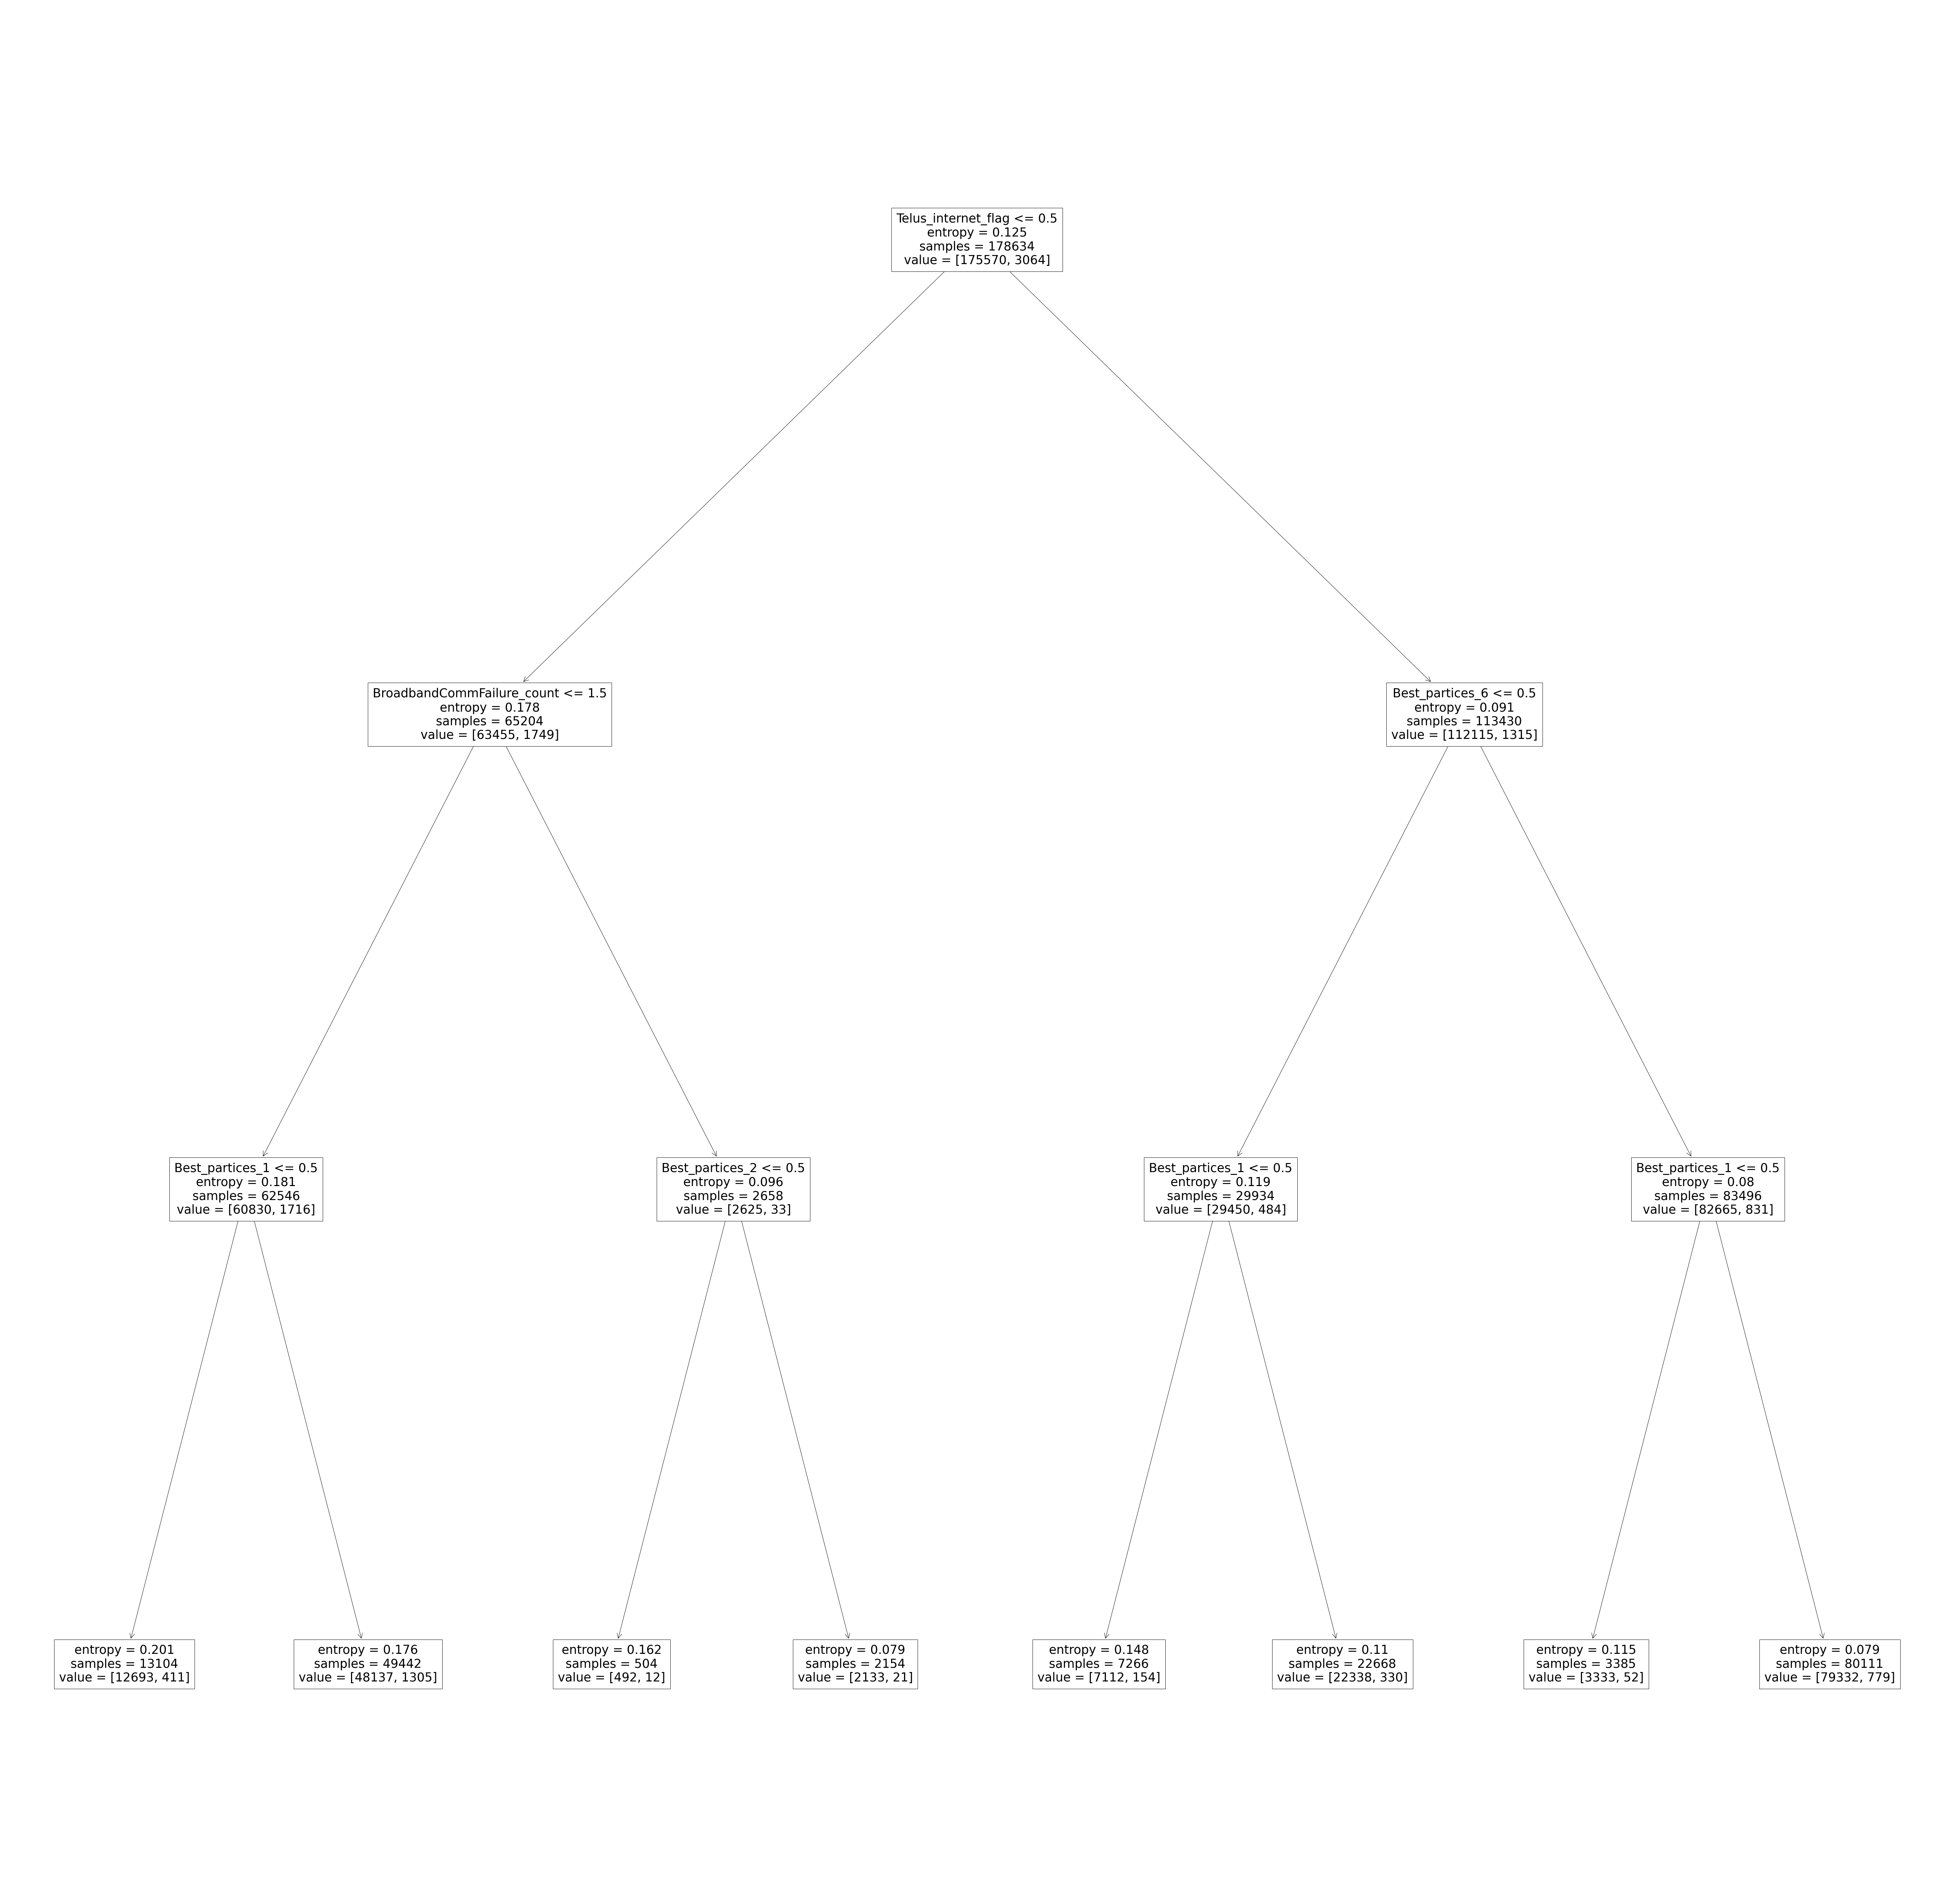

In [430]:

figure(figsize=(100, 100))

tree.plot_tree(decision_tree,feature_names=X.columns.tolist())


In [309]:
411*100/13104

3.1364468864468864

In [310]:
1305*100/49442

2.6394563326726264